## User Identification From Walking Activity

- Author: Ryan Inghilterra
- Date: 4.29.21

- Dataset: https://archive.ics.uci.edu/ml/datasets/User+Identification+From+Walking+Activity#

**Prompt:** imagine you are working at a company that develops personalized health and lifestyle recommendations for users based on their activity patterns, which are recorded via a wearable device. Before giving recommendations, your manager asks you to assess the viability of the recommendation system by first seeing if you can identify users using only their accelerometer data. In this assignment, you will design and implement an experiment to answer this question. 

In [17]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import os

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py

from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    make_scorer,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
)

warnings.filterwarnings(action="once")
np.set_printoptions(suppress=True)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

%matplotlib inline

In [18]:
date = dt.datetime.today().strftime("%m_%d_%Y")
print(date)

07_14_2021


In [19]:
DATA_DIR = "./User Identification From Walking Activity/"

### Read in data and create single dataframe to use

In [20]:
df_list = []
for dir_file in os.listdir(DATA_DIR):
    if dir_file[-4:] == ".csv":
        df = pd.read_csv(DATA_DIR + dir_file, header=None)
        df.columns = ["time_step", "x_accel", "y_accel", "z_accel"]
        df["user_id"] = int(dir_file[:-4])
        df_list.append(df)
all_df = pd.concat(df_list)
# lets sort by user_id and time_step
all_df = all_df.sort_values(["user_id", "time_step"])

In [21]:
print(all_df.shape)
all_df.head()

(149332, 5)


,time_step,x_accel,y_accel,z_accel,user_id
0,0.00000,0.69464,3.17350,7.50480,1
1,0.03064,0.14982,3.48680,9.27550,1
2,0.06976,-0.29965,1.94770,9.11200,1
3,0.09982,-1.68890,1.41650,10.12000,1
4,0.12982,-2.17930,0.95342,10.92400,1


So ~150,000 total samples

### Quick understanding of data

plot number of samples

In [22]:
samples_df = pd.DataFrame(all_df.user_id.value_counts()).reset_index()
samples_df.columns = ["user_id", "total_samples"]
samples_df = samples_df.sort_values("user_id")

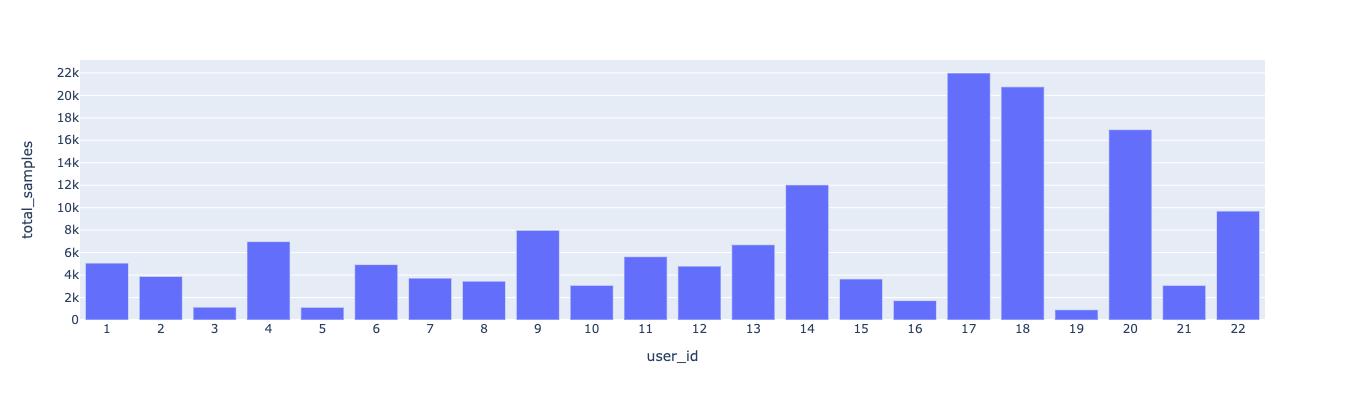

In [23]:
fig = px.bar(samples_df, x="user_id", y="total_samples")
fig.update_xaxes(nticks=23)
fig.update_yaxes(nticks=20)
fig.update_layout(width=800, height=400)
py.offline.iplot(fig)

any null values?

In [24]:
all_df.isna().sum()

time_step    0
x_accel      0
y_accel      0
z_accel      0
user_id      0
dtype: int64

In [25]:
all_df = all_df.sort_values("time_step")

general description

In [26]:
all_df.describe()

,time_step,x_accel,y_accel,z_accel,user_id
count,149332.00000,149332.00000,149332.00000,149332.00000,149332.00000
mean,185.55992,-1.65533,8.76939,0.55558,13.89730
std,167.16083,2.86697,2.77223,3.14762,5.92145
min,0.00000,-19.57200,-10.92400,-14.98200,1.00000
25%,56.78000,-3.14630,7.16430,-1.22580,9.00000
50%,127.37000,-1.30760,8.85320,-0.08172,16.00000
75%,273.68250,-0.04086,10.33800,1.53910,18.00000
max,676.68000,19.31400,19.57200,19.34100,22.00000


Note that acceleration can be negative

### Train / Test split

I want to break up train and test split based on time for each user, before doing any window or lag computations so I know test set will be completely separate and future based from training set

In [27]:
train_df_list = []
test_df_list = []
for user_id in sorted(all_df.user_id.unique()):
    adf = all_df[all_df["user_id"] == user_id].reset_index(drop=True)
    test_index = round(len(adf) * 0.7)
    # print(len(adf), test_index)
    user_train_df = adf[:test_index]
    user_test_df = adf[test_index:]
    train_df_list.append(user_train_df)
    test_df_list.append(user_test_df)
train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

In [28]:
print(train_df.shape, test_df.shape)

(104532, 5) (44800, 5)


In [29]:
train_df.describe()

,time_step,x_accel,y_accel,z_accel,user_id
count,104532.00000,104532.00000,104532.00000,104532.00000,104532.00000
mean,130.04721,-1.71654,8.82758,0.49362,13.89742
std,117.01097,2.87894,2.82310,3.07268,5.92140
min,0.00000,-19.57200,-9.61600,-14.98200,1.00000
25%,39.78000,-3.25530,7.27330,-1.22580,9.00000
50%,89.30100,-1.37570,8.89410,-0.08172,16.00000
75%,192.47250,-0.04086,10.37900,1.45740,18.00000
max,474.50000,15.89500,19.57200,19.34100,22.00000


In [30]:
test_df.describe()

,time_step,x_accel,y_accel,z_accel,user_id
count,44800.00000,44800.00000,44800.00000,44800.00000,44800.00000
mean,315.08790,-1.51250,8.63360,0.70014,13.89701
std,192.94463,2.83375,2.64481,3.31144,5.92163
min,20.31000,-17.73400,-10.92400,-12.55800,1.00000
25%,136.94000,-2.83300,6.89190,-1.26670,9.00000
50%,269.72500,-1.14410,8.68980,-0.04086,16.00000
75%,498.20000,-0.00000,10.14700,1.68890,18.00000
max,676.68000,19.31400,19.42300,19.34100,22.00000


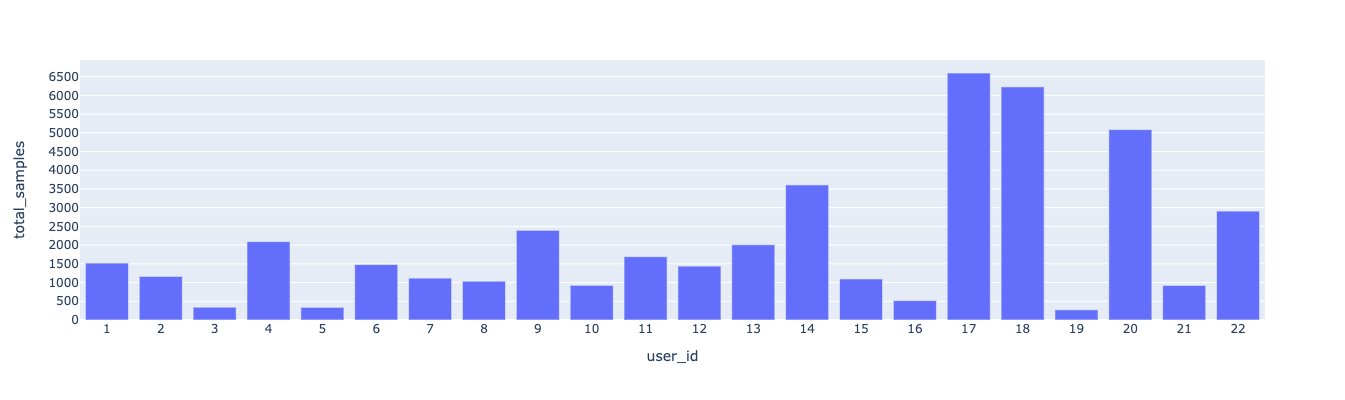

In [31]:
test_samples_df = pd.DataFrame(test_df.user_id.value_counts()).reset_index()
test_samples_df.columns = ["user_id", "total_samples"]
test_samples_df = test_samples_df.sort_values("user_id")

fig = px.bar(test_samples_df, x="user_id", y="total_samples")
fig.update_xaxes(nticks=23)
fig.update_yaxes(nticks=20)
fig.update_layout(width=800, height=400)
py.offline.iplot(fig)

Write to csv

In [32]:
train_df.to_csv("user_ident_class_train.csv", index=False)
test_df.to_csv("user_ident_class_test.csv", index=False)

### Feature Engineering and EDA

#### Time Step Difff

combine time_diff between each step, since small dataset and limited time, do basic for look per user

In [33]:
def time_step_calc_df(df):

    all_df_list = []
    for user_id in sorted(df.user_id.unique()):
        adf = df[df["user_id"] == user_id].reset_index(drop=True)
        # get previous time_step values
        shift_time_step = adf["time_step"].shift(1)
        # create new column with prev time step values
        adf["prev_time_step"] = shift_time_step
        # the first row will be null since no previous value, so fill 0
        adf["prev_time_step"] = adf["prev_time_step"].fillna(0)
        # calc diff
        adf["time_step_diff"] = adf["time_step"] - adf["prev_time_step"]
        all_df_list.append(adf)

    all_df = pd.concat(all_df_list)
    print(all_df.shape)
    return all_df

In [34]:
all_df.head(2)

,time_step,x_accel,y_accel,z_accel,user_id
0,0.00000,0.69464,3.17350,7.50480,1
0,0.00000,-1.07600,4.01800,8.47190,20


In [35]:
train_df = time_step_calc_df(train_df)
train_df.head(2)

(104532, 7)


,time_step,x_accel,y_accel,z_accel,user_id,prev_time_step,time_step_diff
0,0.00000,0.69464,3.17350,7.50480,1,0.00000,0.00000
1,0.03064,0.14982,3.48680,9.27550,1,0.00000,0.03064


In [36]:
test_df = time_step_calc_df(test_df)
test_df.head(2)

(44800, 7)


,time_step,x_accel,y_accel,z_accel,user_id,prev_time_step,time_step_diff
0,107.38000,-4.98500,10.18800,-2.83300,1,0.00000,107.38000
1,107.41000,-3.97710,8.28120,-3.44590,1,107.38000,0.03000


#### Resultant Vector

Want to combine x,y,z acceleration together into single number, could be useful feature

In [37]:
def res_vector_calc_row(row):
    x = row["x_accel"]
    y = row["y_accel"]
    z = row["z_accel"]
    res = res_vector_calc(x, y, z)
    return res


def res_vector_calc(x, y, z):
    res = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return res

In [38]:
train_df["res_vector"] = train_df.apply(lambda row: res_vector_calc_row(row), axis=1)
test_df["res_vector"] = test_df.apply(lambda row: res_vector_calc_row(row), axis=1)

In [39]:
train_df.head(2)

,time_step,x_accel,y_accel,z_accel,user_id,prev_time_step,time_step_diff,res_vector
0,0.00000,0.69464,3.17350,7.50480,1,0.00000,0.00000,8.17775
1,0.03064,0.14982,3.48680,9.27550,1,0.00000,0.03064,9.91035


#### Window and Lag Feature Engineering

for modeling with this type of time series classification we need to transform our data into a format where each row represents a window. So each row window will have the summary statistics of the window as features (columns), and each lag feature as a column, which are precisely all the values within the window that window sequential order.

In [40]:
def get_window_feat_df(df, window_size):
    adf = df.copy()
    # lag should be (window size - 1) since window includes current
    lags = list(range(1, window_size))
    lag_cols = ["x_accel", "y_accel", "z_accel", "res_vector"]
    for lag_col in lag_cols:
        for lag in lags:
            adf = add_lag_cols(adf, lag, lag_col)

    window_cols = ["x_accel", "y_accel", "z_accel", "res_vector", "time_step_diff"]
    for window_col in window_cols:
        adf = add_roll_window_mean_std(adf, window_size, window_col)

    # remove nulls
    adf = adf.dropna()
    return adf

In [41]:
def add_lag_cols(df, lag_num, col):
    df_list = []
    for user_id in sorted(df.user_id.unique()):
        adf = df[df["user_id"] == user_id].reset_index(drop=True)
        # get previous time_step values
        lag_col = adf[col].shift(lag_num)
        # create new column
        lag_col_name = "{0}_lag{1}".format(col, lag_num)
        adf[lag_col_name] = lag_col
        df_list.append(adf)

    fdf = pd.concat(df_list)
    return fdf

In [42]:
def add_roll_window_mean_std(df, window_size, col):
    df_list = []
    for user_id in sorted(df.user_id.unique()):
        adf = df[df["user_id"] == user_id].reset_index(drop=True)
        window = adf[col].rolling(window=window_size)
        wmean_col = window.mean()
        wstd_col = window.std()
        mean_col_name = "{0}_rwindow{1}_mean".format(col, window_size)
        std_col_name = "{0}_rwindow{1}_std".format(col, window_size)
        adf[mean_col_name] = wmean_col
        adf[std_col_name] = wstd_col
        df_list.append(adf)

    fdf = pd.concat(df_list)
    return fdf

The windowing is using complete overlap, so for example if df has 5 rows (timestamps), result window_df for window size 2 would be (rows 1-2, 2-3, 3-4, 4-5)

In [43]:
w2_train_df = get_window_feat_df(train_df, 2)
w5_train_df = get_window_feat_df(train_df, 5)
w10_train_df = get_window_feat_df(train_df, 10)
w25_train_df = get_window_feat_df(train_df, 25)

w2_test_df = get_window_feat_df(test_df, 2)
w5_test_df = get_window_feat_df(test_df, 5)
w10_test_df = get_window_feat_df(test_df, 10)
w25_test_df = get_window_feat_df(test_df, 25)

In [44]:
w50_train_df = get_window_feat_df(train_df, 50)
w50_test_df = get_window_feat_df(test_df, 50)

In [45]:
w2_test_df.head()

,time_step,x_accel,y_accel,z_accel,user_id,prev_time_step,time_step_diff,res_vector,x_accel_lag1,y_accel_lag1,z_accel_lag1,res_vector_lag1,x_accel_rwindow2_mean,x_accel_rwindow2_std,y_accel_rwindow2_mean,y_accel_rwindow2_std,z_accel_rwindow2_mean,z_accel_rwindow2_std,res_vector_rwindow2_mean,res_vector_rwindow2_std,time_step_diff_rwindow2_mean,time_step_diff_rwindow2_std
1,107.41000,-3.97710,8.28120,-3.44590,1,107.38000,0.03000,9.81172,-4.98500,10.18800,-2.83300,11.69066,-4.48105,0.71269,9.23460,1.34831,-3.13945,0.43339,10.75119,1.32861,53.70500,75.90791
2,107.44000,-5.85670,8.92130,-4.63090,1,107.41000,0.03000,11.63339,-3.97710,8.28120,-3.44590,9.81172,-4.91690,1.32908,8.60125,0.45262,-4.03840,0.83792,10.72255,1.28812,0.03000,0.00000
3,107.47000,-7.77720,9.65680,-4.48110,1,107.44000,0.03000,13.18404,-5.85670,8.92130,-4.63090,11.63339,-6.81695,1.35800,9.28905,0.52008,-4.55600,0.10592,12.40871,1.09647,0.03000,0.00000
4,107.50000,-6.85100,8.11770,-3.44590,1,107.47000,0.03000,11.16725,-7.77720,9.65680,-4.48110,13.18404,-7.31410,0.65492,8.88725,1.08831,-3.96350,0.73200,12.17564,1.42608,0.03000,0.00000
5,107.53000,-2.87390,6.70120,-1.52550,1,107.50000,0.03000,7.44933,-6.85100,8.11770,-3.44590,11.16725,-4.86245,2.81223,7.40945,1.00162,-2.48570,1.35793,9.30829,2.62897,0.03000,0.00000


In [46]:
w10_train_df.columns

Index(['time_step', 'x_accel', 'y_accel', 'z_accel', 'user_id',
       'prev_time_step', 'time_step_diff', 'res_vector', 'x_accel_lag1',
       'x_accel_lag2', 'x_accel_lag3', 'x_accel_lag4', 'x_accel_lag5',
       'x_accel_lag6', 'x_accel_lag7', 'x_accel_lag8', 'x_accel_lag9',
       'y_accel_lag1', 'y_accel_lag2', 'y_accel_lag3', 'y_accel_lag4',
       'y_accel_lag5', 'y_accel_lag6', 'y_accel_lag7', 'y_accel_lag8',
       'y_accel_lag9', 'z_accel_lag1', 'z_accel_lag2', 'z_accel_lag3',
       'z_accel_lag4', 'z_accel_lag5', 'z_accel_lag6', 'z_accel_lag7',
       'z_accel_lag8', 'z_accel_lag9', 'res_vector_lag1', 'res_vector_lag2',
       'res_vector_lag3', 'res_vector_lag4', 'res_vector_lag5',
       'res_vector_lag6', 'res_vector_lag7', 'res_vector_lag8',
       'res_vector_lag9', 'x_accel_rwindow10_mean', 'x_accel_rwindow10_std',
       'y_accel_rwindow10_mean', 'y_accel_rwindow10_std',
       'z_accel_rwindow10_mean', 'z_accel_rwindow10_std',
       'res_vector_rwindow10_mean', 're

### Modeling and Evaluation

Remove time_step and previous time_step, since we don't want our model to rely at all on those values.

For simple MVP, we can start with default parameters and randomforest classifier only.

Later on it would be easier to add in GridSearchCV and different models.

#### Basic Modeling

In [47]:
def train_classifier_evaluate(train_df, test_df, y_col, clf, test_split_perc=0.3):
    X_train = train_df.copy()
    del X_train["user_id"]
    del X_train["time_step"]
    del X_train["prev_time_step"]
    y_train = train_df[y_col]

    X_test = test_df.copy()
    del X_test["user_id"]
    del X_test["time_step"]
    del X_test["prev_time_step"]
    y_test = test_df[y_col]

    clf.fit(X_train, y_train)

    train_predictions = clf.predict(X_train)
    print("train accuracy: {0}".format(accuracy_score(y_train, train_predictions)))
    test_predictions = clf.predict(X_test)
    print("test accuracy: {0}".format(accuracy_score(y_test, test_predictions)))

    return clf, X_train, X_test, y_train, y_test

In [48]:
def plot_feature_importance(clf, feature_names):
    # from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

#### Dummy Classifier

Lets just see what this would look like for sanity check

In [49]:
clf = DummyClassifier(strategy="prior", random_state=0)
_ = train_classifier_evaluate(
    w10_train_df,
    w10_test_df,
    "user_id",
    DummyClassifier(strategy="prior", random_state=0),
)

train accuracy: 0.1474591216669542
test accuracy: 0.14770638087978116


In [50]:
w2_clf, w2_X_train, w2_X_test, w2_y_train, w2_y_test = train_classifier_evaluate(
    w2_train_df, w2_test_df, "user_id", RandomForestClassifier(random_state=0)
)

train accuracy: 1.0
test accuracy: 0.3884050203224798


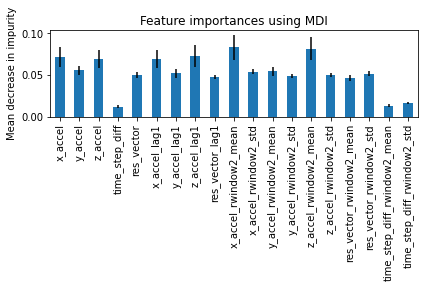

In [51]:
plot_feature_importance(w2_clf, w2_X_train.columns)

In [52]:
w5_clf, w5_X_train, w5_X_test, w5_y_train, w5_y_test = train_classifier_evaluate(
    w5_train_df, w5_test_df, "user_id", RandomForestClassifier(random_state=0)
)

train accuracy: 1.0
test accuracy: 0.5046519949901592


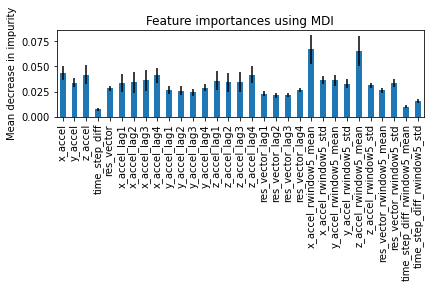

In [53]:
plot_feature_importance(w5_clf, w5_X_train.columns)

In [54]:
w10_clf, w10_X_train, w10_X_test, w10_y_train, w10_y_test = train_classifier_evaluate(
    w10_train_df, w10_test_df, "user_id", RandomForestClassifier(random_state=0)
)

train accuracy: 1.0
test accuracy: 0.5589211246132461


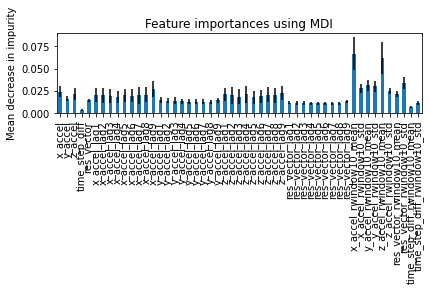

In [55]:
plot_feature_importance(w10_clf, w10_X_train.columns)

In [56]:
%%time
w25_clf, w25_X_train, w25_X_test, w25_y_train, w25_y_test = train_classifier_evaluate(
    w25_train_df, w25_test_df, "user_id", RandomForestClassifier(random_state=0)
)

train accuracy: 1.0
test accuracy: 0.5971946151066136
CPU times: user 1min 46s, sys: 1.5 s, total: 1min 48s
Wall time: 1min 48s


In [57]:
w25_kclf, w25_X_train, w25_X_test, w25_y_train, w25_y_test = train_classifier_evaluate(
    w25_train_df, w25_test_df, "user_id", KNeighborsClassifier()
)

train accuracy: 0.9726645129033499
test accuracy: 0.603835381279364


In [58]:
%%time
w50_clf, w50_X_train, w50_X_test, w50_y_train, w50_y_test = train_classifier_evaluate(
    w50_train_df, w50_test_df, "user_id", RandomForestClassifier(random_state=0)
)

train accuracy: 1.0
test accuracy: 0.6105621883719866
CPU times: user 2min 25s, sys: 2.12 s, total: 2min 27s
Wall time: 2min 28s


This is assuming we want to be able to predict user identification on any given general walking path

#### Confusion Matrix and Accuracy Reports

A good way to visualize how the classifier performs is looking at confusion matrix, as well as precision, recall, and f1 score per class and wighted average

In [59]:
def plot_confusion_matrix(
    clf, X_test, y_test, plot_title="Confusion Matrix", fig_size=(20, 10)
):
    plt.rcParams["figure.figsize"] = (20, 10)
    from sklearn.metrics import plot_confusion_matrix

    disp = plot_confusion_matrix(
        clf, X_test, y_test, values_format="d", cmap=plt.cm.Blues, normalize=None
    )
    disp.ax_.set_title(plot_title)

    plt.show()

In [60]:
def get_classification_report(clf, X_test, y_test, title):
    print(title)
    y_pred = clf.predict(X_test)
    class_report_dic = classification_report(y_test, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report_dic).T
    return class_report_df

In [61]:
w2_class_df = get_classification_report(
    w2_clf, w2_X_test, w2_y_test, "Window 2 Model Classication Report"
)
w2_class_df

Window 2 Model Classication Report


,precision,recall,f1-score,support
1,0.52070,0.41382,0.46114,1520.00000
2,0.11132,0.05155,0.07046,1164.00000
3,0.20238,0.04971,0.07981,342.00000
4,0.18503,0.10272,0.13210,2093.00000
5,0.91139,0.85207,0.88073,338.00000
6,0.46127,0.63176,0.53322,1480.00000
7,0.39122,0.57424,0.46539,1118.00000
8,0.19091,0.06081,0.09224,1036.00000
9,0.28997,0.34990,0.31712,2395.00000
10,0.45505,0.35568,0.39927,925.00000


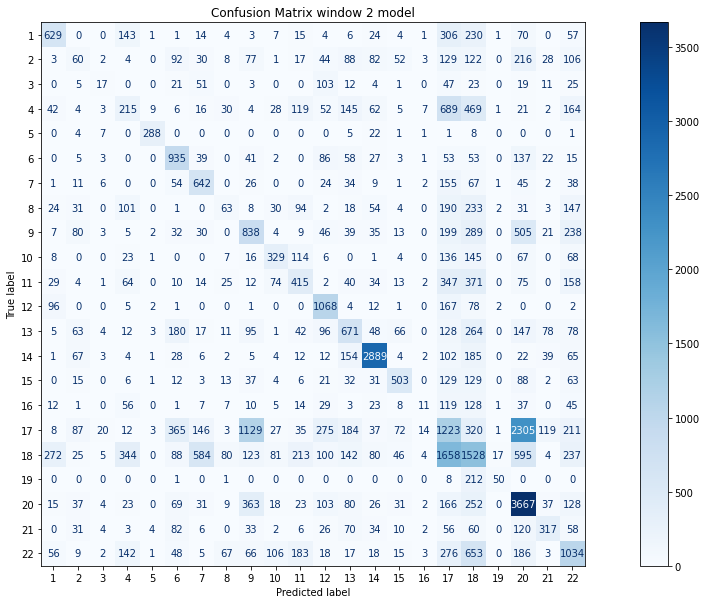

In [62]:
plot_confusion_matrix(w2_clf, w2_X_test, w2_y_test, "Confusion Matrix window 2 model")

In [63]:
w5_class_df = get_classification_report(
    w5_clf, w5_X_test, w5_y_test, "Window 5 Model Classication Report"
)
w5_class_df

Window 5 Model Classication Report


,precision,recall,f1-score,support
1,0.70873,0.63678,0.67083,1517.00000
2,0.15755,0.10422,0.12545,1161.00000
3,0.20175,0.06785,0.10155,339.00000
4,0.31210,0.18756,0.23431,2090.00000
5,0.77143,0.64478,0.70244,335.00000
6,0.56230,0.82803,0.66977,1477.00000
7,0.41888,0.72018,0.52968,1115.00000
8,0.20749,0.06970,0.10435,1033.00000
9,0.37638,0.44105,0.40616,2392.00000
10,0.76387,0.64208,0.69770,922.00000


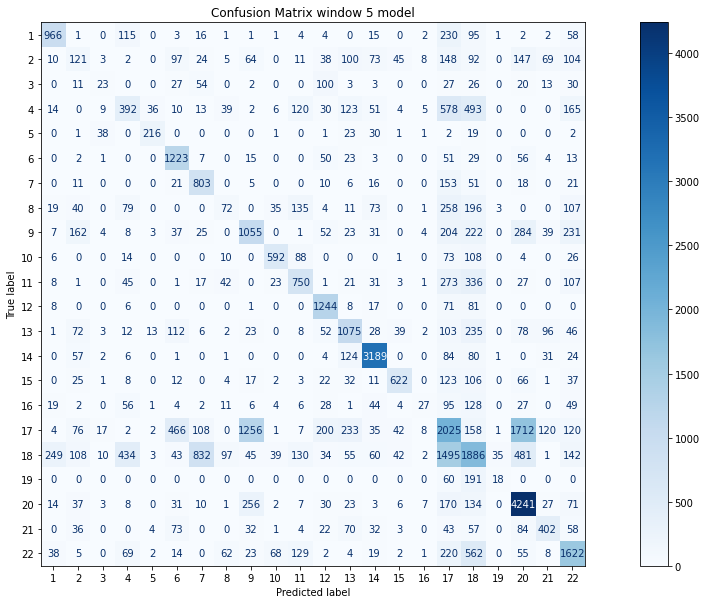

In [64]:
plot_confusion_matrix(w5_clf, w5_X_test, w5_y_test, "Confusion Matrix window 5 model")

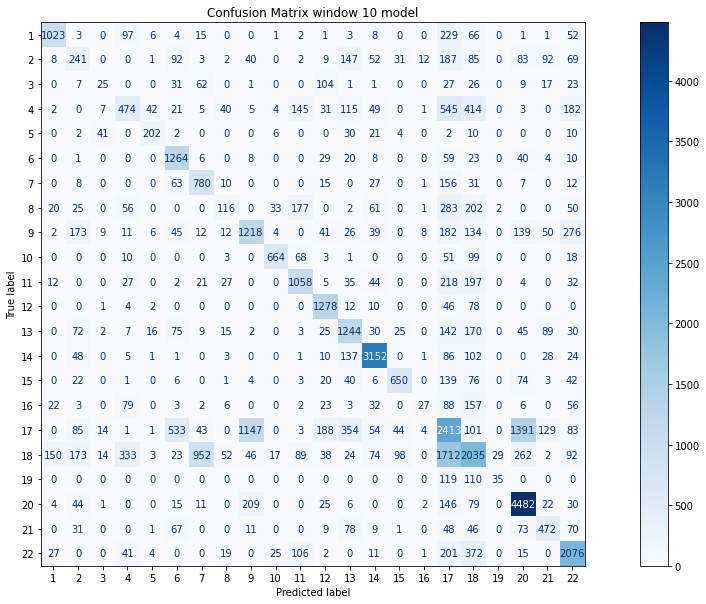

In [65]:
plot_confusion_matrix(
    w10_clf, w10_X_test, w10_y_test, "Confusion Matrix window 10 model"
)

In [66]:
w10_class_df = get_classification_report(
    w10_clf, w10_X_test, w10_y_test, "Window 10 Model Classication Report"
)
w10_class_df

Window 10 Model Classication Report


,precision,recall,f1-score,support
1,0.80551,0.67659,0.73544,1512.00000
2,0.25693,0.20848,0.23018,1156.00000
3,0.21930,0.07485,0.11161,334.00000
4,0.41361,0.22734,0.29341,2085.00000
5,0.70877,0.61212,0.65691,330.00000
6,0.56253,0.85870,0.67975,1472.00000
7,0.40604,0.70270,0.51468,1110.00000
8,0.37908,0.11284,0.17391,1028.00000
9,0.45262,0.51026,0.47972,2387.00000
10,0.88064,0.72410,0.79473,917.00000


In [74]:
w25_class_df = get_classification_report(
    w25_clf, w25_X_test, w25_y_test, "Window 25 Model Classication Report"
)
w25_class_df

Window 25 Model Classication Report


,precision,recall,f1-score,support
1,0.90917,0.68203,0.77939,1497.00000
2,0.33136,0.29360,0.31134,1141.00000
3,0.19417,0.06270,0.09479,319.00000
4,0.43026,0.22802,0.29807,2070.00000
5,0.73333,0.59365,0.65614,315.00000
6,0.61627,0.87852,0.72439,1457.00000
7,0.34551,0.67397,0.45682,1095.00000
8,0.46565,0.12043,0.19137,1013.00000
9,0.46266,0.56155,0.50733,2372.00000
10,0.84176,0.70177,0.76542,902.00000


**Note** the poor performance for prediction on class 2 here above. Especially the 27.5% Recall is very low.

In [75]:
w50_class_df = get_classification_report(
    w50_clf, w50_X_test, w50_y_test, "Window 50 Model Classication Report"
)
w50_class_df

Window 50 Model Classication Report


,precision,recall,f1-score,support
1,0.95318,0.69158,0.80157,1472.00000
2,0.41639,0.33244,0.36971,1116.00000
3,0.26214,0.09184,0.13602,294.00000
4,0.46853,0.22934,0.30794,2045.00000
5,0.66434,0.32759,0.43880,290.00000
6,0.61640,0.87640,0.72376,1432.00000
7,0.36501,0.72150,0.48477,1070.00000
8,0.55507,0.12753,0.20741,988.00000
9,0.42752,0.56796,0.48783,2347.00000
10,0.92431,0.72406,0.81202,877.00000


Accuracy and Balanced accuracy stores on test set for each classifer

In [69]:
def accuracy_scores(clf, X_test, y_test, model_name=""):
    predictions = clf.predict(X_test)
    acc_score = accuracy_score(y_test, predictions)
    # handle class imbalance, interesting other metric
    bal_acc_score = balanced_accuracy_score(y_test, predictions)
    test_acc_str = "{0} - test accuracy: {1:.5f} , balanced test accuracy: {2:.5f}"
    print(test_acc_str.format(model_name, acc_score, bal_acc_score))
    return acc_score, bal_acc_score

In [76]:
w2_acc_score, w2_bal_acc_score = accuracy_scores(
    w2_clf, w2_X_test, w2_y_test, "Window 2 Model"
)

w5_acc_score, w5_bal_acc_score = accuracy_scores(
    w5_clf, w5_X_test, w5_y_test, "Window 5 Model"
)

w10_acc_score, w10_bal_acc_score = accuracy_scores(
    w10_clf, w10_X_test, w10_y_test, "Window 10 Model"
)

w25_acc_score, w25_bal_acc_score = accuracy_scores(
    w25_clf, w25_X_test, w25_y_test, "Window 25 Model"
)

w50_acc_score, w50_bal_acc_score = accuracy_scores(
    w50_clf, w50_X_test, w50_y_test, "Window 50 Model"
)

Window 2 Model - test accuracy: 0.38841 , balanced test accuracy: 0.36728
Window 5 Model - test accuracy: 0.50465 , balanced test accuracy: 0.46375
Window 10 Model - test accuracy: 0.55892 , balanced test accuracy: 0.51449
Window 25 Model - test accuracy: 0.59719 , balanced test accuracy: 0.54059
Window 50 Model - test accuracy: 0.61056 , balanced test accuracy: 0.54334


Lets plot the precision, recall, f1 score weighted averages, want weighted average since class imbalance

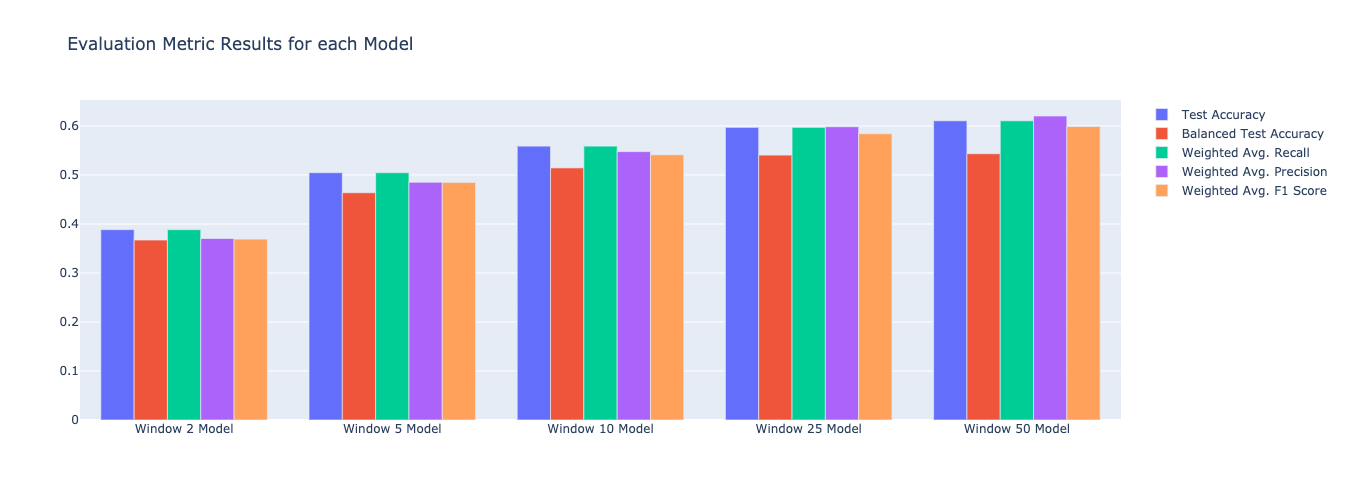

In [78]:
model_names = [
    "Window 2 Model",
    "Window 5 Model",
    "Window 10 Model",
    "Window 25 Model",
    "Window 50 Model"
]
test_accs = [w2_acc_score, w5_acc_score, w10_acc_score, w25_acc_score, w50_acc_score]
bal_test_accs = [
    w2_bal_acc_score,
    w5_bal_acc_score,
    w10_bal_acc_score,
    w25_bal_acc_score,
    w50_bal_acc_score,
]
weighted_avg_recall = [
    w2_class_df.loc["weighted avg"]["recall"],
    w5_class_df.loc["weighted avg"]["recall"],
    w10_class_df.loc["weighted avg"]["recall"],
    w25_class_df.loc["weighted avg"]["recall"],
    w50_class_df.loc["weighted avg"]["recall"],
]
weighted_avg_precision = [
    w2_class_df.loc["weighted avg"]["precision"],
    w5_class_df.loc["weighted avg"]["precision"],
    w10_class_df.loc["weighted avg"]["precision"],
    w25_class_df.loc["weighted avg"]["precision"],
    w50_class_df.loc["weighted avg"]["precision"],
]
weighted_avg_f1 = [
    w2_class_df.loc["weighted avg"]["f1-score"],
    w5_class_df.loc["weighted avg"]["f1-score"],
    w10_class_df.loc["weighted avg"]["f1-score"],
    w25_class_df.loc["weighted avg"]["f1-score"],
    w50_class_df.loc["weighted avg"]["f1-score"],
]

fig = go.Figure(
    data=[
        go.Bar(name="Test Accuracy", x=model_names, y=test_accs),
        go.Bar(name="Balanced Test Accuracy", x=model_names, y=bal_test_accs),
        go.Bar(name="Weighted Avg. Recall", x=model_names, y=weighted_avg_recall),
        go.Bar(name="Weighted Avg. Precision", x=model_names, y=weighted_avg_precision),
        go.Bar(name="Weighted Avg. F1 Score", x=model_names, y=weighted_avg_f1),
    ]
)

fig.update_layout(
    barmode="group",
    height=500,
    width=900,
    title="Evaluation Metric Results for each Model",
)
fig.update_yaxes(dtick=0.1)
py.offline.iplot(fig)

Note that weighted average is used for recall, precision, f1-score evaluation metrics  because there is some class imbalance

### Result Summary

Predicting User Identity looks feasible based on the experiment setup, execution, and results, with the larger the time window of sequential sensor readings for a user, the better we could predict the user's identity.

This was with with no hyperparameter tuning or cross validation during training and with basic lag features and window statistics features as described in more detail in this notebook.

For evaluation we looked at test set accuracy, and since the classes are unbalanced also looked at balanced test accuracy. In addition we look at a per class and avg breakdown of precision, recall, and f1 score metrics. And finally also plot a confusion matrix which gives us insight on where our model needs improvement.

There is a chance that our test scores are overly optimistic based on the standard randomized training / testing split which I used. This can be a problem with time series data / features. More research and investigation is needed to see if I need to split my train and test set with non overlapping windows across the two sets, see here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit

Model improvement is expected with more hyperparameter tuning, more complex models types, and most importantly more feature engineering.

### Extra

#### Plotly Interactive Plotting

Useful plotting function to allow comparing and visualizing sensor features from the users at different timeframes

In [155]:
def plot(df, user_ids_list, min_time_step, max_time_step, col):
    plot_df = df[df["user_id"].isin(user_ids_list)]
    plot_df = plot_df[plot_df["time_step"] > min_time_step]
    plot_df = plot_df[plot_df["time_step"] < max_time_step]
    fig = px.line(
        plot_df[["time_step", col, "user_id"]], x="time_step", y=col, color="user_id"
    )
    fig.update_layout()
    py.offline.iplot(fig)

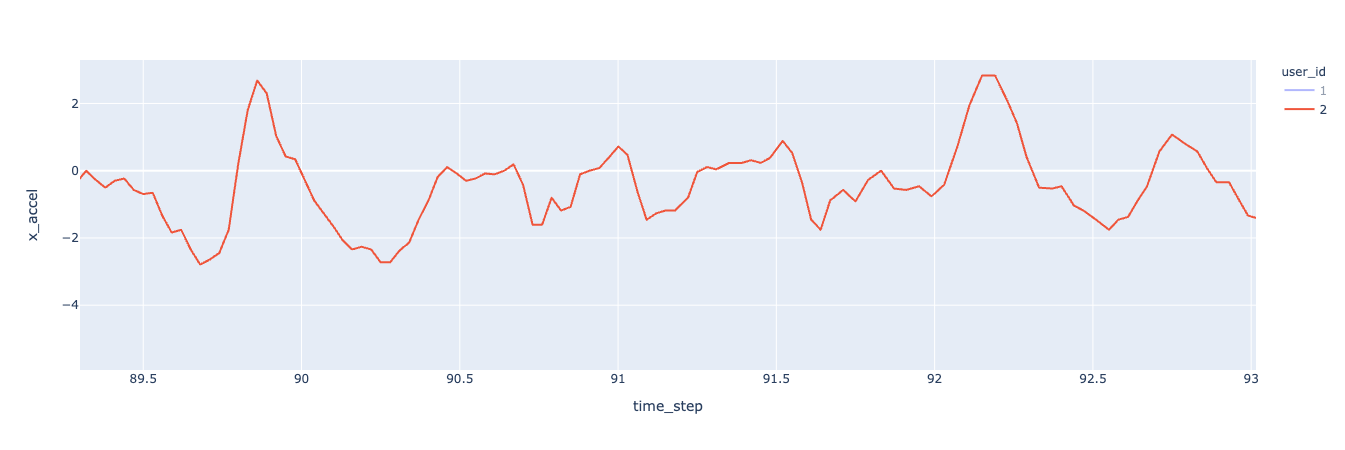

In [164]:
plot(train_df, [1, 2], 0, 200, "x_accel")

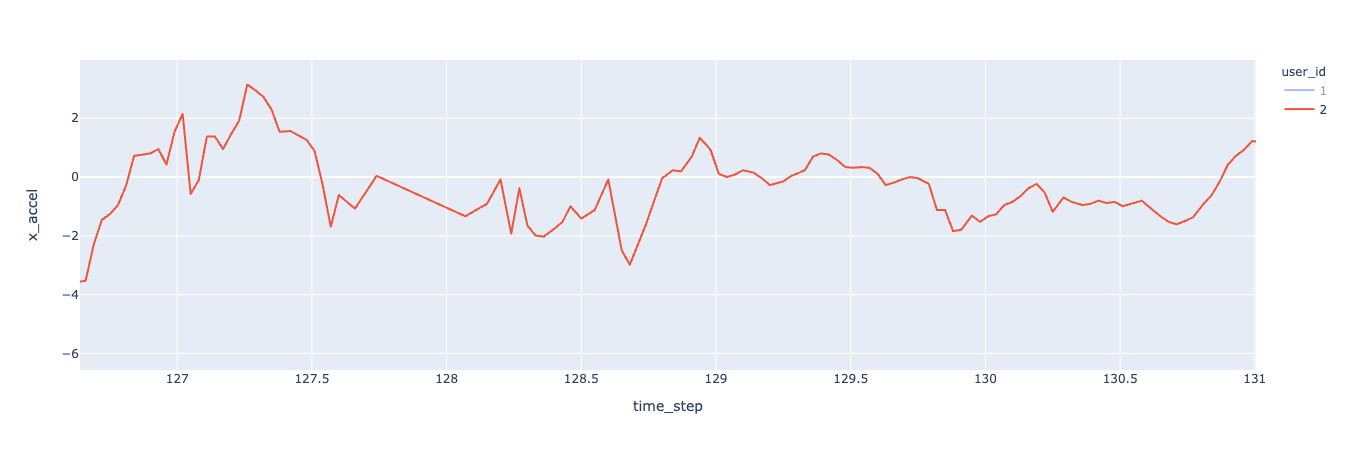

In [163]:
plot(test_df, [1, 2], 40, 500, "x_accel")

In [165]:
train_df[train_df.user_id == 2].describe()

,time_step,x_accel,y_accel,z_accel,user_id,prev_time_step,time_step_diff,res_vector
count,2717.00000,2717.00000,2717.00000,2717.00000,2717.00000,2717.00000,2717.00000,2717.00000
mean,47.49660,-0.47839,9.43867,0.18452,2.00000,47.46226,0.03434,9.74929
std,27.51266,1.59575,1.74830,1.73544,0.00000,27.51370,0.04424,1.70742
min,0.00000,-6.23810,2.91480,-6.40160,2.00000,0.00000,0.00000,3.07052
25%,23.70000,-1.37570,8.92130,-0.80360,2.00000,23.67000,0.03000,9.29207
50%,47.52000,-0.57205,9.53420,-0.00000,2.00000,47.49000,0.03000,9.66043
75%,71.97000,0.42223,9.88840,1.03510,2.00000,71.94000,0.03010,10.10556
max,93.29000,6.89190,19.04100,8.85320,2.00000,93.25000,1.13500,19.58963


In [166]:
test_df[test_df.user_id == 2].describe()

,time_step,x_accel,y_accel,z_accel,user_id,prev_time_step,time_step_diff,res_vector
count,1165.00000,1165.00000,1165.00000,1165.00000,1165.00000,1165.00000,1165.00000,1165.00000
mean,112.04981,-0.67446,8.96356,1.46494,2.00000,111.93712,0.11270,9.81965
std,10.82004,1.61006,2.27468,3.02685,0.00000,11.29286,2.73364,1.85406
min,93.33100,-5.81590,2.60150,-3.86820,2.00000,0.00000,0.02900,4.17551
25%,102.85000,-1.72980,7.66830,-0.42223,2.00000,102.82000,0.03000,8.70925
50%,111.76000,-0.80360,9.00300,0.57205,2.00000,111.73000,0.03000,9.63999
75%,121.79000,0.19068,10.27000,2.07030,2.00000,121.76000,0.03000,10.81083
max,131.29000,7.66830,16.08600,12.21700,2.00000,131.26000,93.33100,16.18769


In [161]:
test_df.head(2)

,time_step,x_accel,y_accel,z_accel,user_id,prev_time_step,time_step_diff,res_vector
0,107.38000,-4.98500,10.18800,-2.83300,1,0.00000,107.38000,11.69066
1,107.41000,-3.97710,8.28120,-3.44590,1,107.38000,0.03000,9.81172


#### GridSearchCV Example

Want to show how gridsearchcv can be used for hyperameter tuning and cross validation. Would use as a next step

In [175]:
def grid_search_train(df, y_col, clf, parameters, criterion, test_split_perc=0.3):
    X = df.copy()
    del X["user_id"]
    del X["time_step"]
    del X["prev_time_step"]
    y = df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_split_perc, random_state=0
    )

    # Type of scoring used to compare parameter combinations
    acc_scorer = make_scorer(accuracy_score)

    # Run the grid search
    grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
    grid_obj = grid_obj.fit(X_train, y_train)

    # Set the clf to the best combination of parameters
    clf = grid_obj.best_estimator_

    return clf, X_train, X_test, y_train, y_test

In [176]:
%%time

# Choose some parameter combinations to try
parameters = {"n_estimators": [5, 10, 50, 100]}
criterion = {"gini", "entropy"}

cv_clf, X_train_cv, X_test_cv, y_train_cv, y_test_cv = grid_search_train(
    w5_df, "user_id", RandomForestClassifier(random_state=0), parameters, criterion
)

CPU times: user 7min 25s, sys: 11.1 s, total: 7min 36s
Wall time: 7min 39s


In [178]:
# Fit the best algorithm to the data.
cv_clf.fit(X_train_cv, y_train_cv)
predictions = cv_clf.predict(X_test_cv)
print(accuracy_score(y_test_cv, predictions))

0.7713628445079733
